<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/training_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Training, fine-tuning, and transfer learning with pyannote.audio

In this tutorial, you will learn how to use pyannote.audio to

- train a voice activity detection model from scratch,
- fine-tune a pretrained speaker segmentation model,
- perform transfer learning (from speaker segmentation to overlapped speech detection)


## Tutorial setup

### `Google Colab` setup

If you are running this tutorial on `Colab`, execute the following commands in order to setup `Colab` environment. These commands will install `pyannote.audio` and download a mini version of the `AMI` corpus.

In [ ]:
!pip install -qq pyannote.audio==3.1.1
!pip install -qq ipython==7.34.0
!git clone https://github.com/pyannote/AMI-diarization-setup.git
%cd ./AMI-diarization-setup/pyannote/
!bash ./download_ami_mini.sh
%cd /content

⚠ Restart the runtime (Runtime > Restart session).

## Data preparation

See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [2]:

from pyannote.database import registry, FileFinder

#registry.load_database("AMI-diarization-setup/pyannote/database.yml")
#ami = registry.get_protocol('AMI.SpeakerDiarization.mini')

file_finder = FileFinder()
registry.load_database("/home/nele_pauline_suffo/projects/pyannote-audio-train/database.yml")
protocol = registry.get_protocol('ChildLens.SpeakerDiarization.audio', preprocessors={"audio": lambda x: str(file_finder(x))})

## Training a voice activity detection model from scratch

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [3]:
#from pyannote.audio.tasks import VoiceActivityDetection
#vad_task = VoiceActivityDetection(ami, duration=2.0, batch_size=128)

from pyannote.audio.tasks import MultiLabelSegmentation
mls_task = MultiLabelSegmentation(protocol, duration=2.0, batch_size=128)

Protocol ChildLens.SpeakerDiarization.audio does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad_task`) for which it is being trained:

In [4]:
#from pyannote.audio.models.segmentation import PyanNet
#vad_model = PyanNet(task=vad_task, sincnet={'stride': 10})

from pyannote.audio.models.segmentation import PyanNet
#mls_model = SSeRiouSS(task=mls_task)
mls_model = PyanNet(task=mls_task, sincnet={'stride': 10})


Now that everything is ready, let's train with `pytorch-ligthning`!

In [5]:
import pytorch_lightning as pl

trainer = pl.Trainer(devices=1, max_epochs=1)
trainer.fit(mls_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))

  | Name              | Type             | Params | Mode  | In sizes      | Out sizes                                  
-----------------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | train | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 589 K  | train | [1, 115, 60]  | [[1, 115, 256], [[4, 1, 128], [4, 1, 128]]]
2 | linear         

/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Epoch 0:   0%|          | 0/642 [00:00<?, ?it/s] 

/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/torch_audiomentations/core/transforms_interface.py:221: UserWarning: target_rate is required by Identity. It has been automatically inferred from targets shape to 58. If this is incorrect, you can pass it directly.
  warnings.warn(
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/torch_audiomentations/core/transforms_interface.py:221: UserWarning: target_rate is required by Identity. It has been automatically inferred from targets shape to 58. If this is incorrect, you can pass it directly.
  warnings.warn(
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/torch_audiomentations/core/transforms_interface.py:221: UserWarning: target_rate is required by Identity. It has been automatically inferred from targets shape to 58. If this is incorrect, you can pass it directly.
  warnings.warn(
/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-p

Epoch 0: 100%|██████████| 642/642 [10:59<00:00,  0.97it/s, v_num=10, loss/val=0.108]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 642/642 [10:59<00:00,  0.97it/s, v_num=10, loss/val=0.108]


For the purpose of this tutorial, the model is trained for only 1 epoch. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

## Inference

Once trained, the model can be applied to a test file:
Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

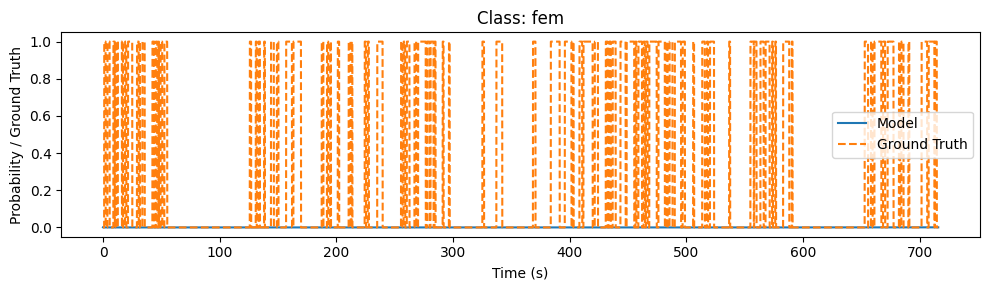

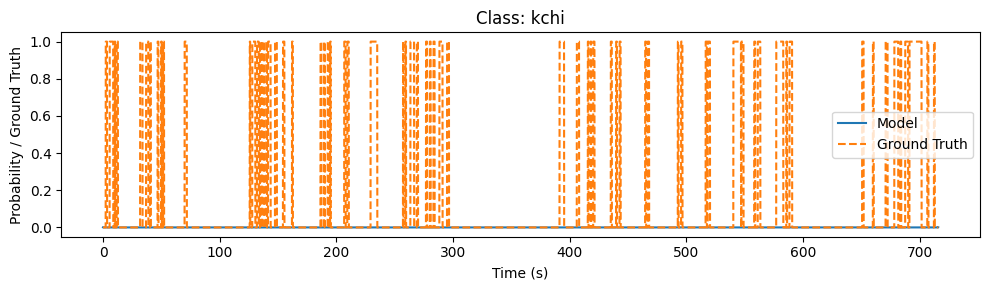

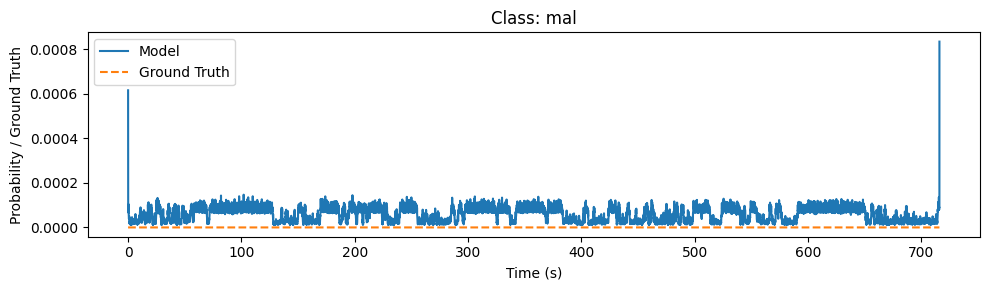

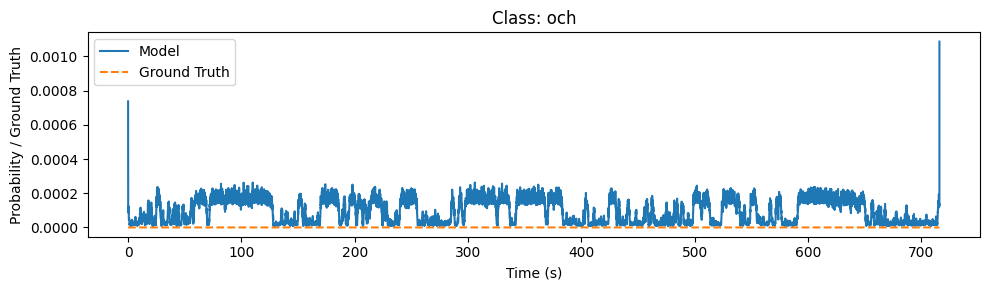

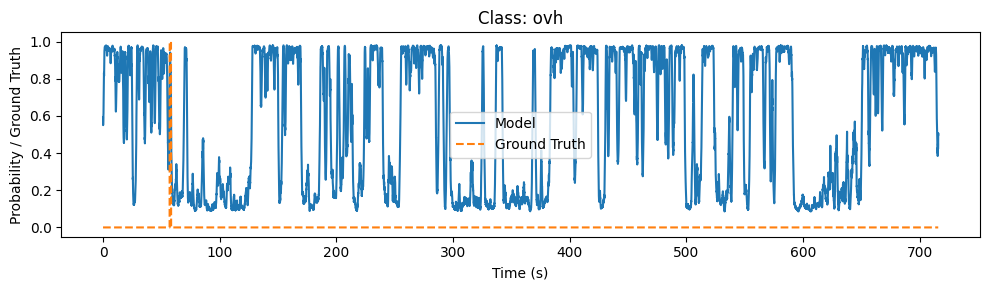

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Inference

# run inference on the test file
mls = Inference(mls_model, window="sliding", duration=2.0, step=0.5)
test_file = next(protocol.test())
mls_probability = mls(test_file)

# define time axis
num_frames = mls_probability.data.shape[0]
start = mls_probability.sliding_window.start
step = mls_probability.sliding_window.step
time = np.arange(num_frames) * step + start

class_names = mls_model.specifications.classes

# create a figure for each class
# and plot the model probabilities and ground truth
# (ground truth is 1 if the class is present, 0 otherwise)
for idx, class_name in enumerate(class_names):
    plt.figure(figsize=(10, 3))
    # Model probabilities
    plt.plot(time, mls_probability.data[:, idx], label="Model", color="C0")
    # Ground truth
    gt = np.zeros_like(time)
    for segment, _, label in test_file["annotation"].itertracks(yield_label=True):
        if label == class_name:
            mask = (time >= segment.start) & (time < segment.end)
            gt[mask] = 1
    plt.plot(time, gt, "--", label="Ground Truth", color="C1")
    plt.title(f"Class: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Probability / Ground Truth")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Pipeline

Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.6`: mark region as `active` when probability goes above 0.6
- `offset=0.4`: switch back to `inactive` when probability goes below 0.4
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [16]:
from pyannote.audio.pipelines import MultiLabelSegmentation as MultiLabelSegmentationPipeline
pipeline = MultiLabelSegmentationPipeline(segmentation=mls_model, share_min_duration=True, fscore=True)

# Define the initial parameters for the pipeline
initial_params = {
    "thresholds": {
        "kchi": {"onset": 0.6, "offset": 0.4},
        "och": {"onset": 0.6, "offset": 0.4},
        "fem": {"onset": 0.6, "offset": 0.4},
        "mal": {"onset": 0.6, "offset": 0.4},
        "ovh": {"onset": 0.6, "offset": 0.4},
    },
    "min_duration_on": 0.0,
    "min_duration_off": 0.0,
}

# Instantiate the pipeline with the parameters
pipeline.instantiate(initial_params)

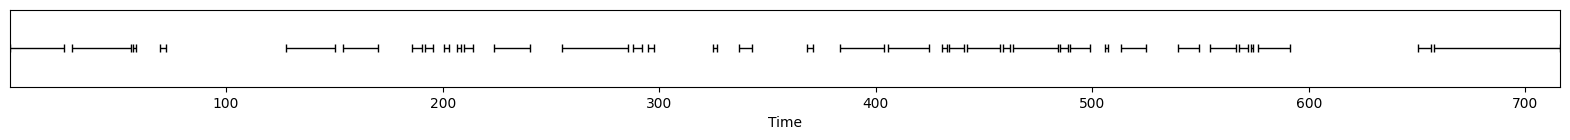

In [13]:
pipeline(test_file).get_timeline()

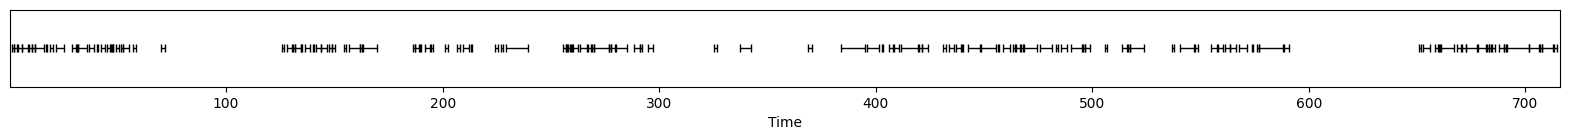

In [14]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

## Evaluation

In [ ]:
print()

In [ ]:
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure, DetectionErrorRate

# Initialize the metric
class_labels = ["kchi", "och", "fem", "mal", "ovh"]
metric = DetectionPrecisionRecallFMeasure(classes=class_labels)

# Evaluate on the test set
for file in protocol.test():
    # Apply the multi-label segmentation pipeline
    hypothesized = pipeline(file)

    # Evaluate its output
    _ = metric(
        file['annotation'],     # Reference annotation
        hypothesized,           # Hypothesized annotation
        uem=file['annotated']   # Evaluated regions
    )

# Compute and report the macro-average F1-score
f1_score = abs(metric)  # DetectionPrecisionRecallFMeasure returns a value between 0 and 1
print(f"Macro-average F1-score: {f1_score:.2f}")

# Get per-class metrics
per_class_metrics = metric.compute_metrics()
print("Per-class F1-scores:")
for class_label in class_labels:
    f1 = per_class_metrics[class_label]['fmeasure']
    print(f"  {class_label}: {f1:.2f}")

/home/nele_pauline_suffo/.conda/envs/pyannote-new/lib/python3.8/site-packages/pyannote/database/protocol/protocol.py:140: UserWarning: Existing precomputed key "annotation" has been modified by a preprocessor.
  warnings.warn(msg.format(key=key))


Macro-average F1-score: 0.86
Per-class F1-scores:


TypeError: tuple indices must be integers or slices, not str

In [20]:
per_class_metrics

(0.8350485059394074, 0.8759838141981925, 0.8550264850806305)

## Optimizing Pipeline Hyperparameter

While good enough, the hyper-parameters that we chose manually, we can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [ ]:
pipeline.freeze({'min_duration_on': 0.0, 'min_duration_off': 0.0})

In [ ]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()),
               warm_start=initial_params,
               n_iterations=20,
               show_progress=False)

optimized_params = optimizer.best_params
print(optimized_params)

In [ ]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = DetectionErrorRate()

for file in protocol.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])

detection_error_rate = abs(metric)
print(f'Detection error rate = {detection_error_rate * 100:.1f}%')